<a href="https://colab.research.google.com/github/n-goyal/python-test/blob/master/Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### tools

In [0]:
#Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date

In [0]:
#data collection
# !pip install nsepy
from nsepy import get_history

### Data collection

In [0]:
tcs = get_history(symbol='TCS',
                    start=date(2018,4,1), 
                    end=date(2019,2,28))

infy = get_history(symbol='INFY',
                    start=date(2018,4,1), 
                    end=date(2019,2,28))

In [200]:
infy.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2018-04-02,INFY,EQ,1131.80,1141.00,1149.55,1121.3,1136.70,1137.15,1135.86,4036351,4.584717e+14,142078,2960225,0.7334
2018-04-03,INFY,EQ,1137.15,1134.70,1143.55,1128.1,1139.40,1140.45,1135.21,2038584,2.314227e+14,114034,1366638,0.6704
2018-04-04,INFY,EQ,1140.45,1144.00,1144.55,1120.0,1122.70,1124.20,1131.81,2406651,2.723879e+14,137029,1472105,0.6117
2018-04-05,INFY,EQ,1124.20,1139.55,1151.30,1129.1,1146.05,1147.55,1140.71,3881772,4.427993e+14,101745,2899162,0.7469
2018-04-06,INFY,EQ,1147.55,1143.00,1146.00,1122.1,1127.55,1127.00,1128.81,2968871,3.351285e+14,137277,1891236,0.6370


In [0]:
#dropping irrelavent columns
def drop(data):
  return data.drop(['Symbol', 'Series', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Turnover', 'Trades', '%Deliverble', 'Deliverable Volume', 'Prev Close'], axis = 1)

In [0]:
tcs = drop(tcs)
infy = drop(infy)

In [203]:
tcs.head()

,Close,Volume
Date,,
2018-04-02,2909.65,831494
2018-04-03,2911.25,968645
2018-04-04,2910.90,1420910
2018-04-05,2957.95,904712
2018-04-06,2950.30,564509


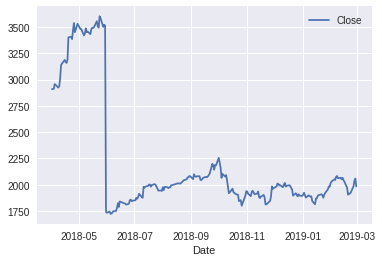

In [204]:
plt.figure()
tcs['Close'].plot()
plt.legend()

###Volume Shock, Price Shock - Dummy time series

In [0]:
# Time to add some new columns
# volume_shock = Volume - Prev Volume
# Percentage_Volume_shock = volume_shock / Prev Volume * 100
# price_shock = Close - Prev Close
# Percentage_close = price_shock / Prev Close * 100

In [0]:
#checking on the shock percentage
def volume_shock(data):
  data['Volume_shock'] = data['Volume'].diff(1)
  data['%Volume_shock'] = data['Volume_shock'] / data['Volume'] * 100
  
def price_shock(data):
  data['Price_shock'] = data['Close'].diff(1)
  data['%Price_shock'] = data['Price_shock'] / data['Close'] * 100

In [0]:
volume_shock(tcs)
price_shock(tcs)

In [233]:
tcs.tail()

,Close,Volume,Volume_shock,%Volume_shock,Price_shock,%Price_shock,%Volume_shock_dummy,%Price_shock_dummy,%PriceV/Svolume_dummy
Date,,,,,,,,,
2019-02-22,1925.65,2271955,-2411964.0,-106.162490,11.45,0.594604,1,0,0
2019-02-25,1985.15,2934880,662925.0,22.587806,59.50,2.997255,1,1,0
2019-02-26,2038.70,6453309,3518429.0,54.521316,53.55,2.626674,1,1,0
2019-02-27,2058.10,4732082,-1721227.0,-36.373567,19.40,0.942617,1,0,0
2019-02-28,1983.45,8454295,3722213.0,44.027480,-74.65,-3.763644,1,1,0


In [0]:
#creating dummy columns to represent the desirable change
#1. volume shock > |10%|
#2. price shock > |2%|
#3. Price shock without Volume shock

In [0]:
def dummy(data):
  data['%Volume_shock_dummy'] = [1 if i>10 or i<-10 else 0 for i in data['%Volume_shock']]
  data['%Price_shock_dummy'] = [1 if i>2 or i<-2 else 0 for i in data['%Price_shock']]
  data['%PriceV/Svolume_dummy'] = [1 if (data['%Volume_shock_dummy'][i]==0 and data['%Price_shock_dummy'][i]==1) else 0 for i in range(len(data['%Price_shock']))]

In [0]:
dummy(tcs)

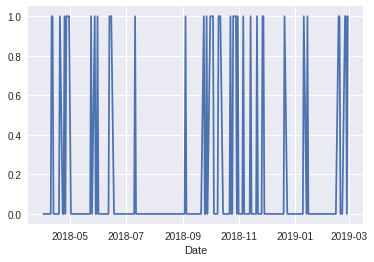

In [234]:
tcs['%Price_shock_dummy'].plot()

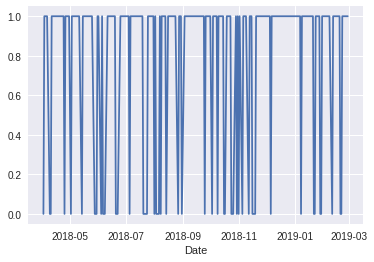

In [235]:
tcs['%Volume_shock_dummy'].plot()

### Moving Averages

In [0]:
# Moving Window Average Function
def moving_avg(data, num_weeks):
  
  for i in range(4):
    window = data['Close'].rolling(window=num_weeks*7*(i+1),  
                                   center = False)
    #averaging over the window
    data['window_'+str(num_weeks*(i+1))] = window.mean()

In [0]:
moving_avg(tcs, 4)

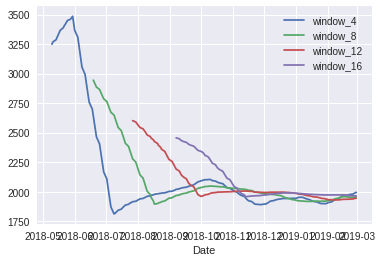

In [247]:
plt.figure()
tcs['window_4'].plot()
tcs['window_8'].plot()
tcs['window_12'].plot()
tcs['window_16'].plot()
plt.legend()

In [0]:
tcs['window10'] = tcs['Close'].rolling(window=10, center=False).mean()
tcs['window75'] = tcs['Close'].rolling(window=75, center=False).mean()

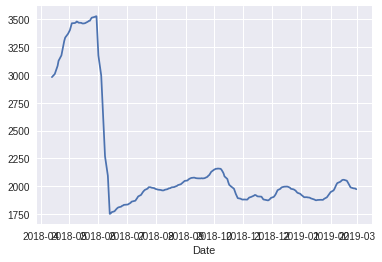

In [257]:
tcs['window10'].plot()

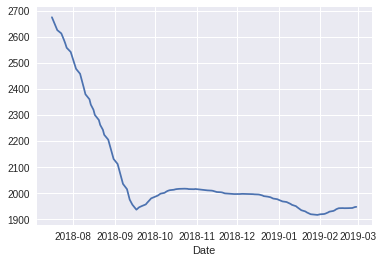

In [258]:
tcs['window75'].plot()

In [264]:
tcs.isna().sum()

Close                      0
Volume                     0
Volume_shock               1
%Volume_shock              1
Price_shock                1
%Price_shock               1
%Volume_shock_dummy        0
%Price_shock_dummy         0
%PriceV/Svolume_dummy      0
window_4                  27
window_8                  55
window_12                 83
window_16                111
window10                   9
window75                  74
dtype: int64

In [265]:
tcs.shape
#As we can see that out of a year(almost) the stock market was working only for 229 days.
#this incorporates a discrepancy in rolling window because the holidays have not considered.

(229, 15)

### Visualizations